In [1]:
import ee
ee.Authenticate()


Successfully saved authorization token.


In [2]:
ee.Initialize(project='astrotourism-darksky')
print("Earth engine initialized")

Earth engine initialized


<>:63: SyntaxWarning: invalid escape sequence '\c'
<>:63: SyntaxWarning: invalid escape sequence '\c'
C:\Users\User\AppData\Local\Temp\ipykernel_16148\1011394673.py:63: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("Radiance ($nW/cm^2 \cdot sr$)", fontsize=12)


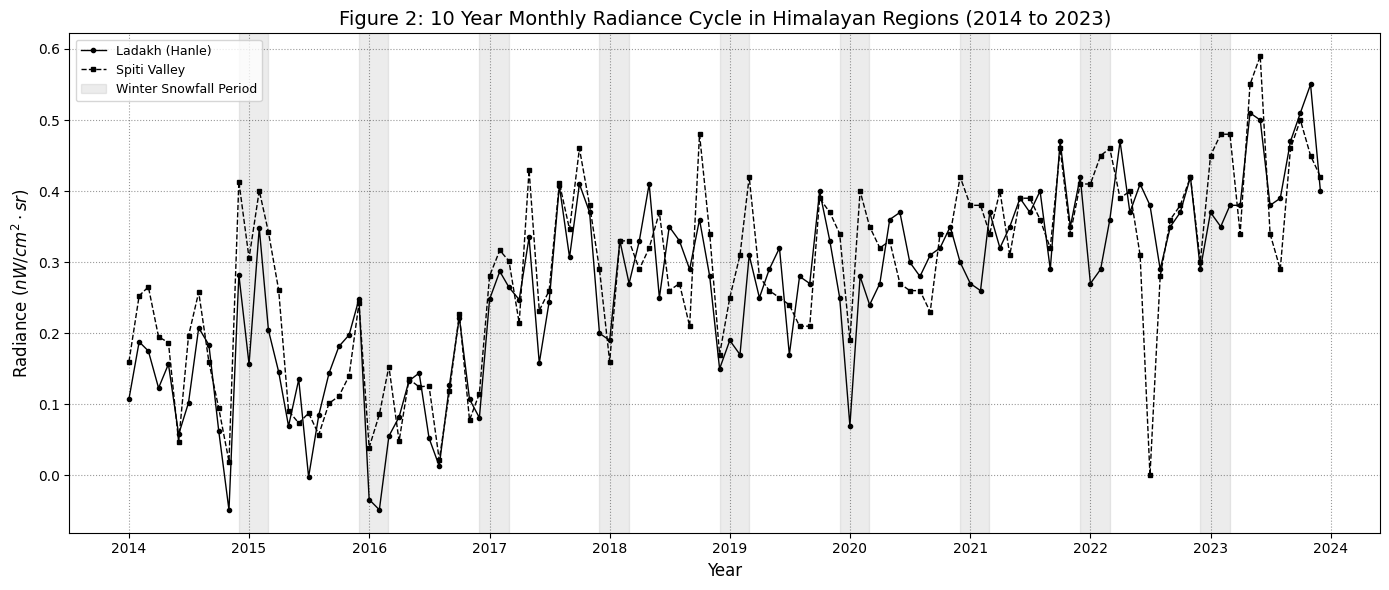

Synchronized 10-year plot saved as 'snowglow_10year_bw_300dpi.png'.


In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
himalayan_rois = {
    "Ladakh (Hanle)": ee.Geometry.Point(78.96, 32.78),
    "Spiti Valley": ee.Geometry.Point(78.00, 32.30)
}
start_month = '2014-01-01'
end_month = '2023-12-31'
collection = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG") \
    .filterDate(start_month, end_month) \
    .select('avg_rad')

def extract_monthly(roi_name, geometry):
    def process_image(img):
        return ee.Feature(None, {
            'date': img.date().format('YYYY-MM-01'),
            'radiance': img.reduceRegion(ee.Reducer.mean(), geometry, 500).get('avg_rad'),
            'region': roi_name
        })
    return collection.map(process_image)

combined_features = extract_monthly("Ladakh (Hanle)", himalayan_rois["Ladakh (Hanle)"]) \
    .merge(extract_monthly("Spiti Valley", himalayan_rois["Spiti Valley"]))

raw_data = combined_features.getInfo()['features']
df_snowglow = pd.DataFrame([f['properties'] for f in raw_data])
df_snowglow['date'] = pd.to_datetime(df_snowglow['date'])

plt.figure(figsize=(14, 6))

styles = {
    "Ladakh (Hanle)": {'marker': 'o', 'linestyle': '-', 'color': 'black'},
    "Spiti Valley": {'marker': 's', 'linestyle': '--', 'color': 'black'}
}

for region in df_snowglow['region'].unique():
    subset = df_snowglow[df_snowglow['region'] == region]
    plt.plot(subset['date'], subset['radiance'], 
             marker=styles[region]['marker'], 
             linestyle=styles[region]['linestyle'],
             color=styles[region]['color'],
             markersize=3, 
             linewidth=1,
             label=region)

# Shading winter months (Dec, Jan, Feb) for the full 10-year span
for year in range(2014, 2023):
    winter_start = pd.to_datetime(f'{year}-12-01')
    winter_end = pd.to_datetime(f'{year+1}-02-28')
    plt.axvspan(winter_start, winter_end, color='gray', alpha=0.15, 
                label='Winter Snowfall Period' if year == 2014 else "")

plt.title("Figure 2: 10 Year Monthly Radiance Cycle in Himalayan Regions (2014 to 2023)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Radiance ($nW/cm^2 \cdot sr$)", fontsize=12)
plt.legend(loc='upper left', fontsize=9, frameon=True)
plt.grid(True, linestyle=':', alpha=0.4, color='black')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.tight_layout()
plt.savefig('snowglow_10year_bw_300dpi.png', dpi=300, facecolor='white')
plt.show()

print("Synchronized 10-year plot saved as 'snowglow_10year_bw_300dpi.png'.")